  folder_name  NN_macro  NN_JK  NN_micro  NN_energy  NN_converged_energy  \
0         476         3     27         8 -40.264620           -40.267847   
1         454         3     25         8 -40.244341           -40.249371   
2         437         3     28         8 -40.254337           -40.258868   
3         451         3     23         7 -40.256488           -40.260321   
4         489         3     29         9 -40.233572           -40.239810   
5         420         3     27         8 -40.257153           -40.260993   
6         415         3     28         8 -40.241373           -40.246861   
7         429         3     21         7 -40.256293           -40.259076   
8         474         3     24         8 -40.261776           -40.265581   
9         453         3     23         7 -40.251882           -40.255960   

   HF_macro  HF_JK  HF_micro  HF_energy  HF_converged_energy  AVAS_macro  \
0         5     61        14 -40.196598           -40.267847           4   
1         5

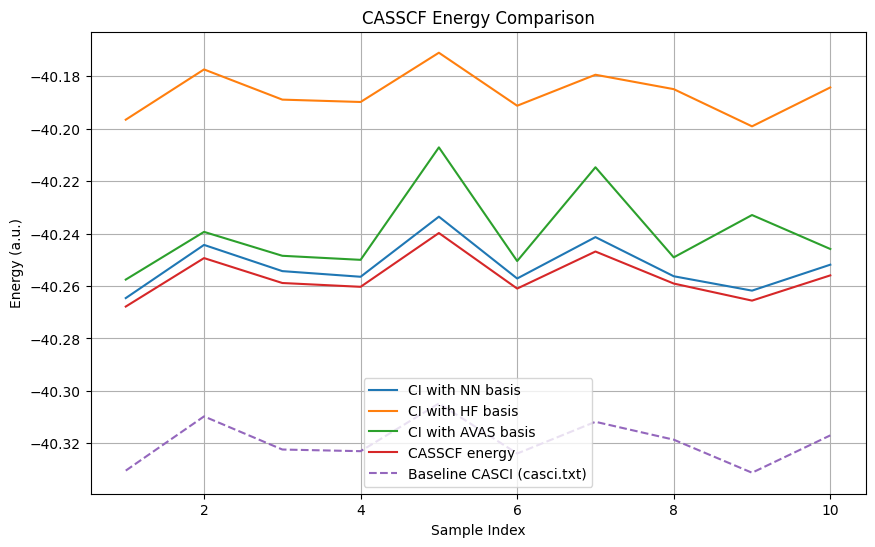

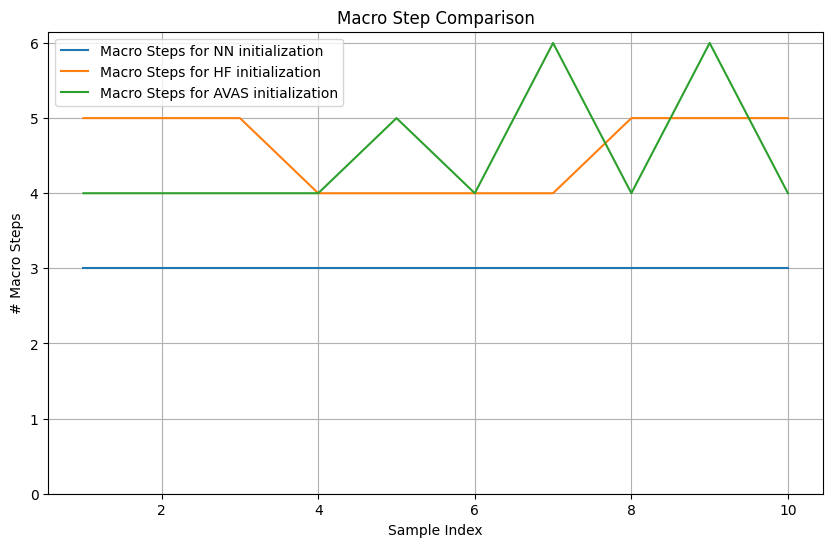

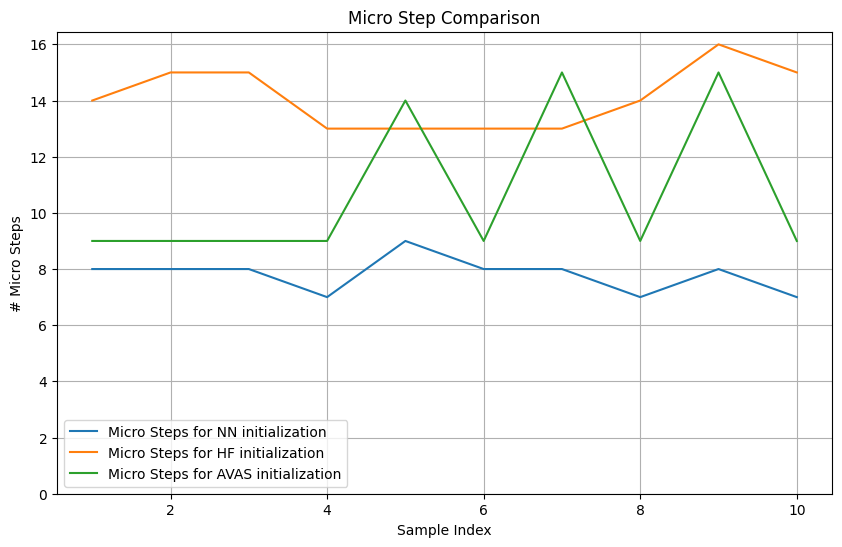

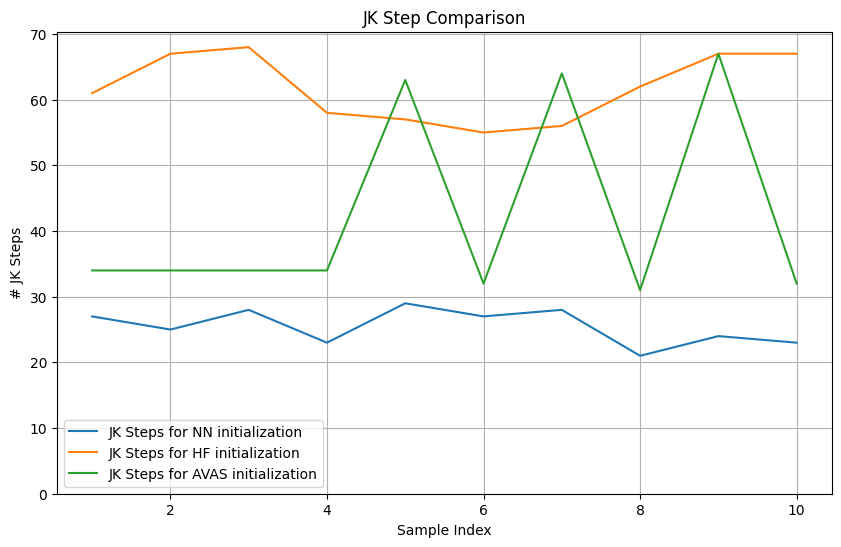

In [2]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Base folder (update if needed)
base_dir = "casscf_output"

# Regex patterns
casscf_pattern = re.compile(
    r"(\d+)-step CASSCF converged in\s+(\d+)\s+macro\s+\(\s+(\d+)\s+JK\s+(\d+)\s+micro\)"
)
# Float with optional exponent, e.g. -1.23e-4
float_re = r"[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?"
casci_pattern = re.compile(rf"CASCI E = ({float_re}).*")
baseline_pattern = re.compile(rf"CASCI E\s*=\s*({float_re})")

results = []

# Loop through folders
if os.path.exists(base_dir):
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        if os.path.isdir(folder_path) and folder.isdigit():
            data = {"folder_name": folder}
            nn_file = os.path.join(folder_path, "casscf_NN_init.txt")
            hf_file = os.path.join(folder_path, "casscf_HF_init.txt")
            avas_file = os.path.join(folder_path, "casscf_AVAS_init.txt")
            casci_file = os.path.join(folder_path, "casci.txt")

            # Initialize flags to track completeness
            valid_nn, valid_hf = False, False

            # NN file
            if os.path.exists(nn_file):
                with open(nn_file, "r", encoding="utf-8", errors="ignore") as f:
                    content = f.read()
                casscf_match = casscf_pattern.search(content)
                casci_matches = casci_pattern.findall(content)
                if casscf_match and len(casci_matches) >= 2:
                    data["NN_macro"] = int(casscf_match.group(2))
                    data["NN_JK"] = int(casscf_match.group(3))
                    data["NN_micro"] = int(casscf_match.group(4))
                    data["NN_energy"] = float(casci_matches[0])
                    data["NN_converged_energy"] = float(casci_matches[1])
                    valid_nn = True

            # HF file
            if os.path.exists(hf_file):
                with open(hf_file, "r", encoding="utf-8", errors="ignore") as f:
                    content = f.read()
                casscf_match = casscf_pattern.search(content)
                casci_matches = casci_pattern.findall(content)
                if casscf_match and len(casci_matches) >= 2:
                    data["HF_macro"] = int(casscf_match.group(2))
                    data["HF_JK"] = int(casscf_match.group(3))
                    data["HF_micro"] = int(casscf_match.group(4))
                    data["HF_energy"] = float(casci_matches[0])
                    data["HF_converged_energy"] = float(casci_matches[1])
                    valid_hf = True

            if os.path.exists(avas_file):
                with open(avas_file, "r", encoding="utf-8", errors="ignore") as f:
                    content = f.read()
                casscf_match = casscf_pattern.search(content)
                casci_matches = casci_pattern.findall(content)
                if casscf_match and len(casci_matches) >= 2:
                    data["AVAS_macro"] = int(casscf_match.group(2))
                    data["AVAS_JK"]    = int(casscf_match.group(3))
                    data["AVAS_micro"] = int(casscf_match.group(4))
                    data["AVAS_energy"]            = float(casci_matches[0])
                    data["AVAS_converged_energy"]  = float(casci_matches[1])
                    valid_avas = True

            # Baseline CASCI from casci.txt (optional)
            if os.path.exists(casci_file):
                with open(casci_file, "r", encoding="utf-8", errors="ignore") as f:
                    content = f.read()
                m = baseline_pattern.search(content)
                if m:
                    data["baseline_E"] = float(m.group(1))

            # Include only if both NN and HF are fully valid
            if valid_nn and valid_hf and valid_avas:
                results.append(data)

# Convert to DataFrame and plot
if results:
    df = pd.DataFrame(results)
    df.reset_index(drop=True, inplace=True)
    df["index"] = df.index + 1  # Sequential index
    print(df)

    x = df["index"]

    # Energy comparison plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, df["NN_energy"], label="CI with NN basis")
    plt.plot(x, df["HF_energy"], label="CI with HF basis")
    plt.plot(x, df["AVAS_energy"], label="CI with AVAS basis")
    plt.plot(x, df["HF_converged_energy"], label="CASSCF energy")
    if "baseline_E" in df.columns:
        plt.plot(x, df["baseline_E"], label="Baseline CASCI (casci.txt)", linestyle="--")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (a.u.)")
    plt.title("CASSCF Energy Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Macro step comparison
    plt.figure(figsize=(10, 6))
    plt.plot(x, df["NN_macro"], label="Macro Steps for NN initialization")
    plt.plot(x, df["HF_macro"], label="Macro Steps for HF initialization")
    plt.plot(x, df["AVAS_macro"], label="Macro Steps for AVAS initialization")
    plt.xlabel("Sample Index")
    plt.ylabel("# Macro Steps")
    plt.ylim(bottom=0)
    plt.title("Macro Step Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Micro step comparison
    plt.figure(figsize=(10, 6))
    plt.plot(x, df["NN_micro"], label="Micro Steps for NN initialization")
    plt.plot(x, df["HF_micro"], label="Micro Steps for HF initialization")
    plt.plot(x, df["AVAS_micro"], label="Micro Steps for AVAS initialization")
    plt.xlabel("Sample Index")
    plt.ylabel("# Micro Steps")
    plt.ylim(bottom=0)
    plt.title("Micro Step Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

    # JK step comparison
    plt.figure(figsize=(10, 6))
    plt.plot(x, df["NN_JK"], label="JK Steps for NN initialization")
    plt.plot(x, df["HF_JK"], label="JK Steps for HF initialization")
    plt.plot(x, df["AVAS_JK"], label="JK Steps for AVAS initialization")
    plt.xlabel("Sample Index")
    plt.ylabel("# JK Steps")
    plt.ylim(bottom=0)
    plt.title("JK Step Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data found: all incomplete entries removed.")


FileNotFoundError: [Errno 2] No such file or directory: 'figs/energy_error.pdf'

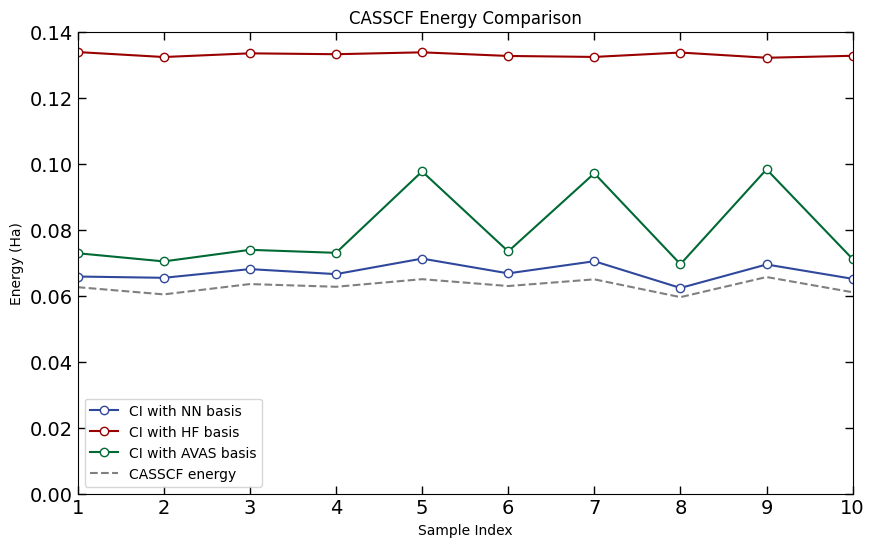

In [3]:

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
# Energy comparison plot
reference_E = df["baseline_E"]
plt.figure(figsize=(10, 6))
plt.plot(x, df["NN_energy"]-reference_E, label="CI with NN basis",marker = 'o', markerfacecolor='white', color=(48/255, 72/255, 156/255))
# plt.plot(x, df["NN_converged_energy"], label="NN Converged Energy")
plt.plot(x, df["HF_energy"]-reference_E, label="CI with HF basis",marker = 'o', markerfacecolor='white', color=(153/255, 0/255, 0/255))
plt.plot(x, df["AVAS_energy"]-reference_E, label="CI with AVAS basis", color=(0/255, 105/255, 52/255), marker='o', markerfacecolor='white')
plt.plot(x, df["NN_converged_energy"]-reference_E, label="CASSCF energy",color='grey', markerfacecolor='white',linestyle='--')
#plt.plot(x, df["HF_converged_energy"], label="CASSCF energy")
plt.tick_params(axis='both', direction='in', length=6, width=1, labelsize=14, top=True, right=True)
plt.xlim(1, 10)
plt.ylim(0., 0.14)
plt.xlabel("Sample Index")
plt.ylabel("Energy (Ha)")
plt.title("CASSCF Energy Comparison")
plt.legend()
plt.savefig("figs/energy_error.pdf", metadata={"TextAsShapes": False})